## Objectives

- Understand and interpret Partial Dependence Plots (PDP) and - Individual Conditional Expectation (ICE) plots.
- Use PDPs to analyze the effect of individual features on model predictions.
- Generate PDPs using scikit-learn for both single and multiple features.
- Apply logistic regression and random forest models to a dataset.
- Evaluate model performance using classification reports and confusion matrices.
- Visualize feature importance and model coefficients.

In [2]:
# Importing Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
def warn (*args, **kwargs):
    pass
import warnings
warnings.filterwarnings('ignore')

sns.set_context('notebook')
sns.set_style('white')

In [3]:
def plot_histograms(X, y=None):
    """
    Creates distribution plots: histograms for numerical features and count plots for categorical features, optionally grouped by target variable
    """
    if y is not None:
        X = X.copy()  # Avoid modifying the original DataFrame
        X['label'] = y  # Add labels for grouping
    
    for col in X.columns:
        plt.figure(figsize=(8, 6))
        if X[col].dtype in ['float64', 'int64']:  # Numerical columns
            # Adjust transparency (alpha) and add more bins for clarity
            sns.histplot(data=X, x=col, hue='label', kde=False, bins=30, alpha=0.5, edgecolor="black")
        else:  # Categorical columns
            # Stacked bar chart for better distinction
            sns.countplot(data=X, x=col, hue='label', dodge=False, alpha=0.8, edgecolor="black")
        plt.title(f"Distribution of {col}")
        plt.tight_layout()
        plt.show()


## Heart Disease Dataset
The Heart Disease Dataset is a medical dataset from the UCI repository, designed to predict the presence of heart disease based on patient demographics, clinical measurements, and test results. It contains 303 samples with features such as age, gender, cholesterol levels, blood pressure, and exercise-induced factors, alongside categorical attributes like chest pain type and thalassemia status. The target variable indicates the presence or absence of heart disease, making it a binary classification problem. This dataset is commonly used for machine learning tasks to explore feature importance and build predictive models in the healthcare domain

In [4]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets 
  
# metadata 
print(heart_disease.metadata['abstract'])

4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach


In [5]:
print(heart_disease.metadata['additional_info'] ['summary'])

This database contains 76 attributes, but all published experiments refer to using a subset of 14 of them.  In particular, the Cleveland database is the only one that has been used by ML researchers to date.  The "goal" field refers to the presence of heart disease in the patient.  It is integer valued from 0 (no presence) to 4. Experiments with the Cleveland database have concentrated on simply attempting to distinguish presence (values 1,2,3,4) from absence (value 0).  
   
The names and social security numbers of the patients were recently removed from the database, replaced with dummy values.

One file has been "processed", that one containing the Cleveland database.  All four unprocessed files also exist in this directory.

To see Test Costs (donated by Peter Turney), please see the folder "Costs" 


In [8]:
X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0


In [9]:
X.shape

(303, 13)

In [10]:
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
dtypes: float64(3), int64(10)
memory usage: 30.9 KB
None


In [11]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')  # Use 'median' if it better suits the data
X['ca'] = imputer.fit_transform(X[['ca']])
X['thal'] = imputer.fit_transform(X[['thal']])

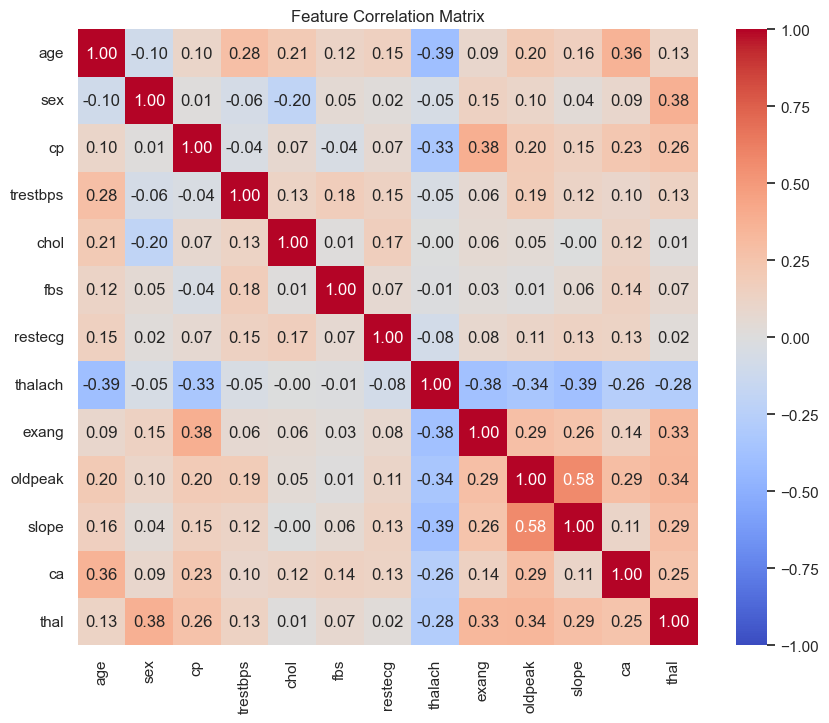

In [12]:
corr_matrix = X.corr()

    # Display the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Feature Correlation Matrix")
plt.show()

### <a id='toc2_2_1_'></a>[Labels in the Heart Disease Dataset](#toc0_)

| **Label Value** | **Description**                                                                 |
|------------------|---------------------------------------------------------------------------------|
| `0`              | No presence of heart disease (negative case).                                  |
| `1`              | Mild heart disease or minimal risk (positive case, low severity).              |
| `2`              | Moderate heart disease (positive case, medium severity).                      |
| `3`              | Severe heart disease (positive case, high severity).                          |

### <a id='toc2_2_2_'></a>[Notes:](#toc0_)
- The labels indicate the progression or severity of heart disease, with `0` representing no disease and higher values representing increasing severity.
- Depending on the task, these labels can be treated as:
  - **Multiclass Classification**: To predict the exact severity class.
  - **Binary Classification**: Combining all `1`, `2`, and `3` into a single "positive" class for presence of disease.
- This distinction is crucial when designing machine learning models.

Let's focus on the two class problems and map classes one two and three into  the positive class  positive case  heart disease  i.e using there variable value of one.


In [13]:
y=y.map(lambda x: 1 if x in {1,2,3} else 0)
y.head()

,num
0,0
1,1
2,1
3,0
4,0


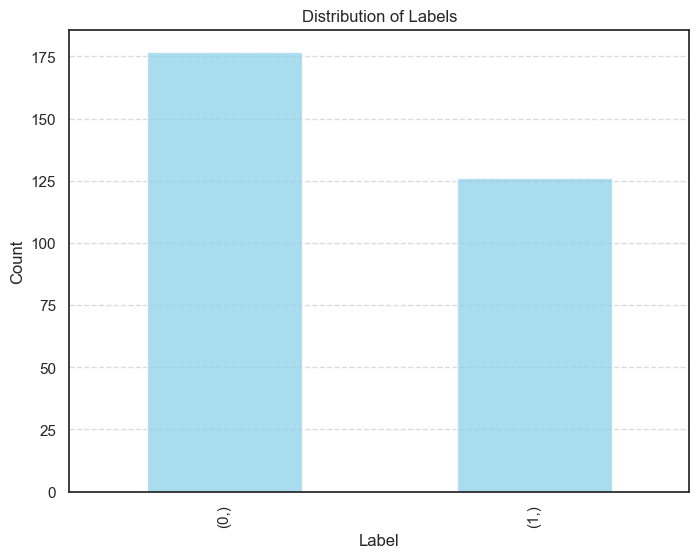

In [14]:
plt.figure(figsize=(8, 6))
y.value_counts().plot(kind='bar', alpha=0.7, color='skyblue')
plt.title("Distribution of Labels")
plt.xlabel("Label")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [15]:
# Compute the mean of features grouped by the labels

data = X.copy()
data['target'] = y
mean_table = data.groupby('target').mean()
del(data)
mean_table

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
target,,,,,,,,,,,,,
0,53.107345,0.581921,2.858757,129.949153,243.429379,0.135593,0.892655,157.073446,0.163842,0.716949,1.457627,0.384275,3.981549
1,56.309524,0.817460,3.579365,134.134921,251.277778,0.166667,1.126984,139.119048,0.555556,1.492857,1.801587,1.076764,5.791541


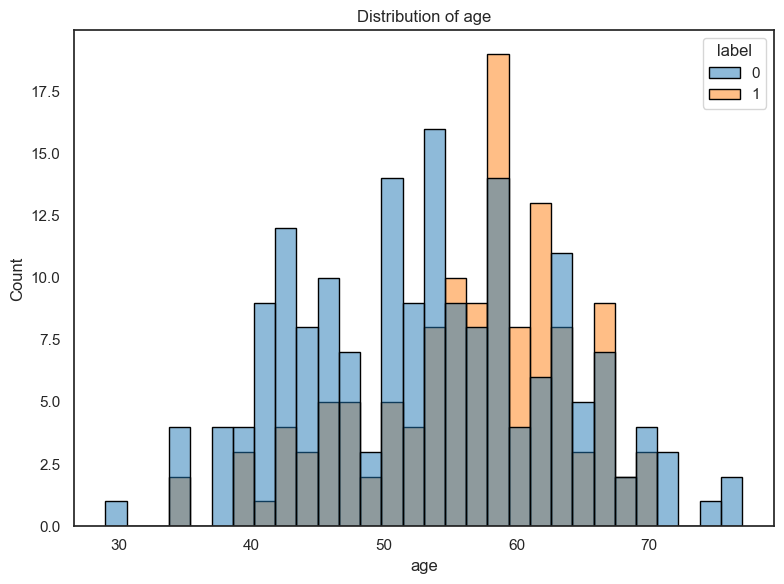

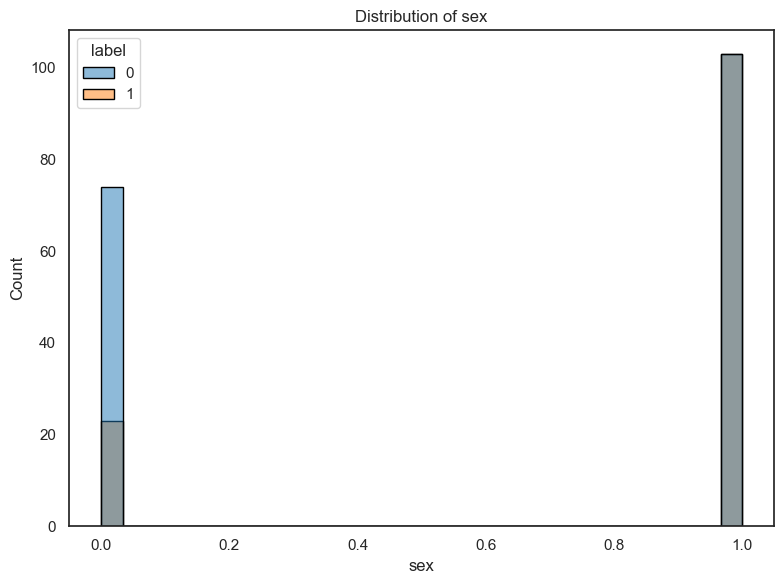

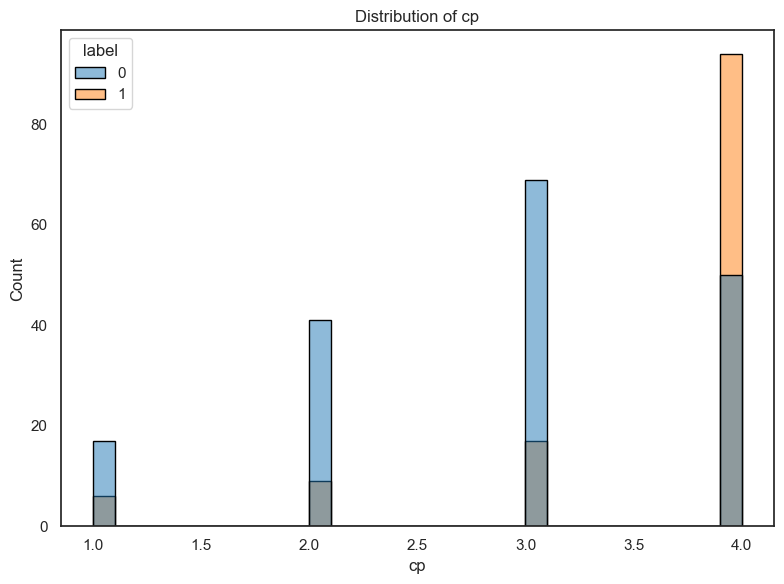

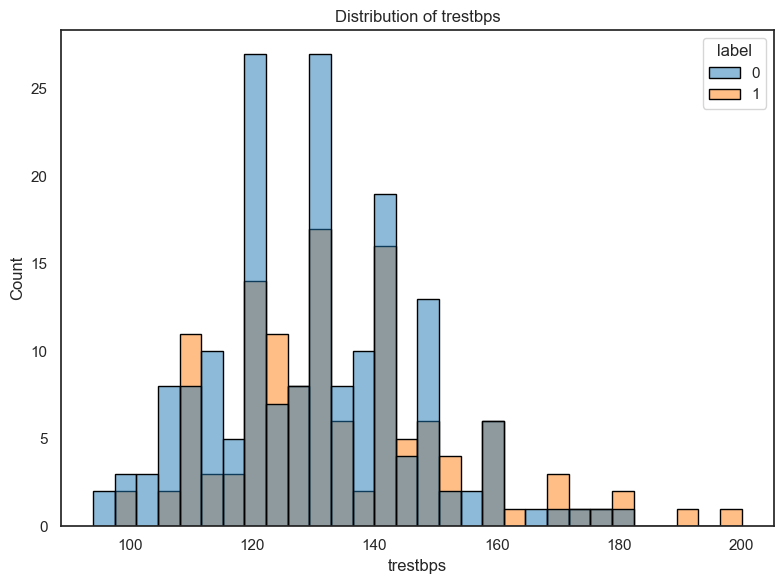

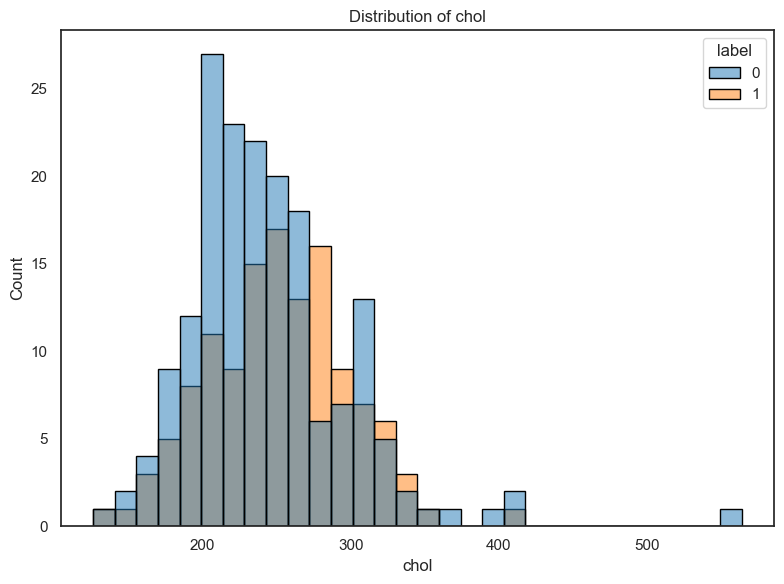

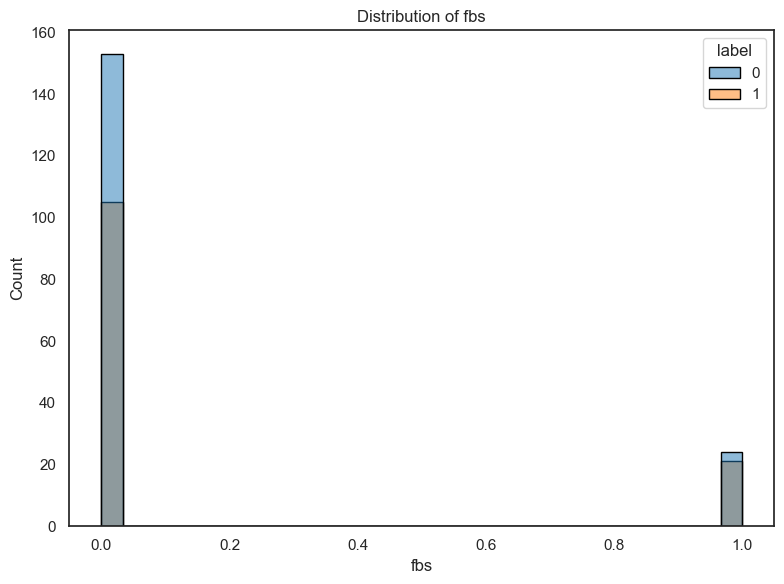

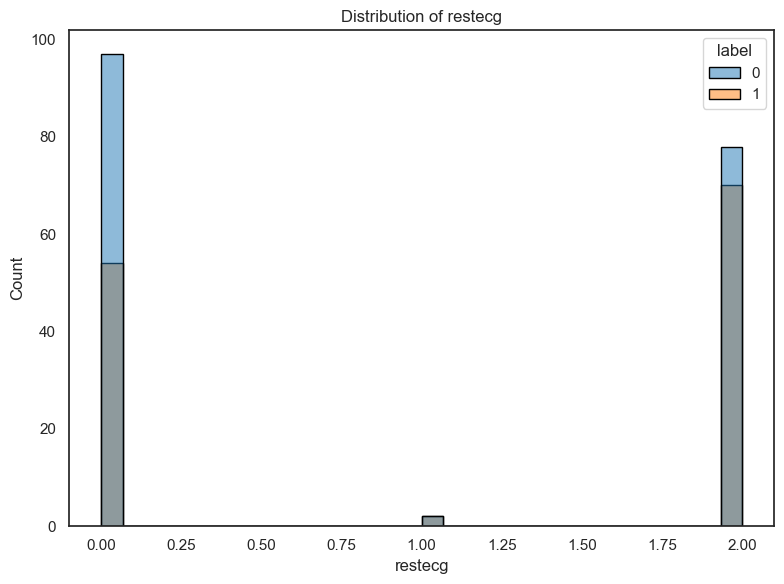

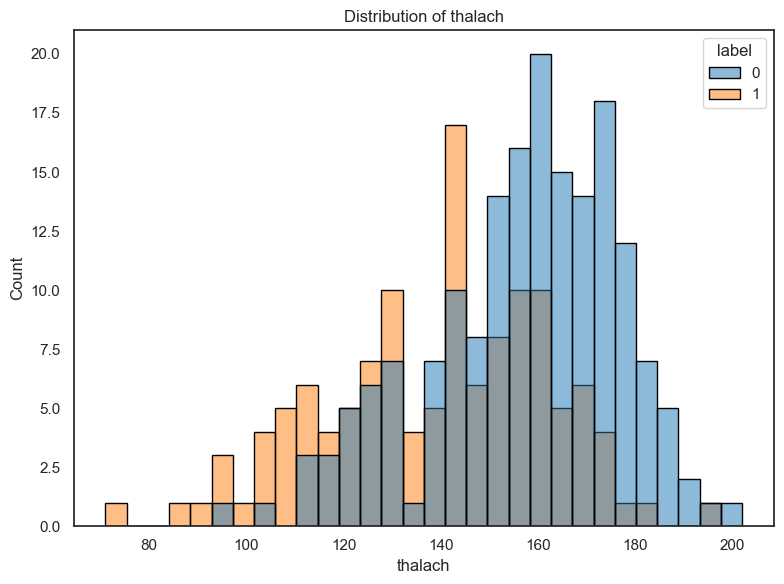

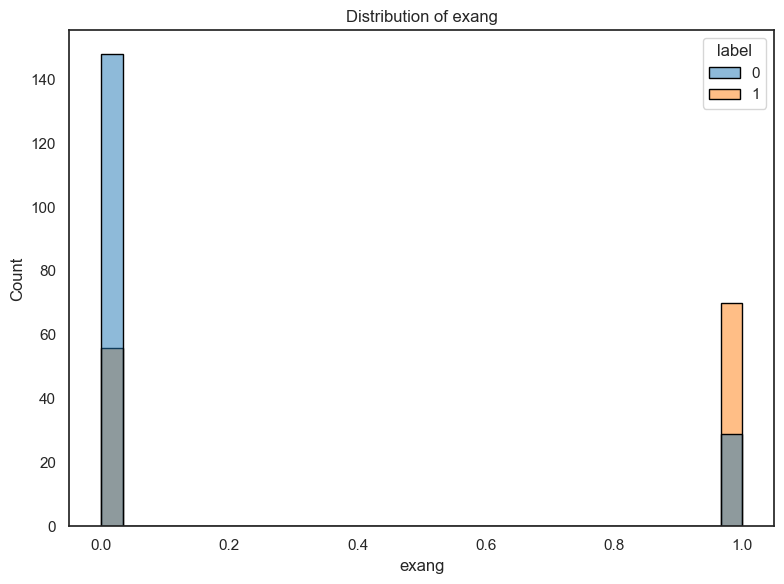

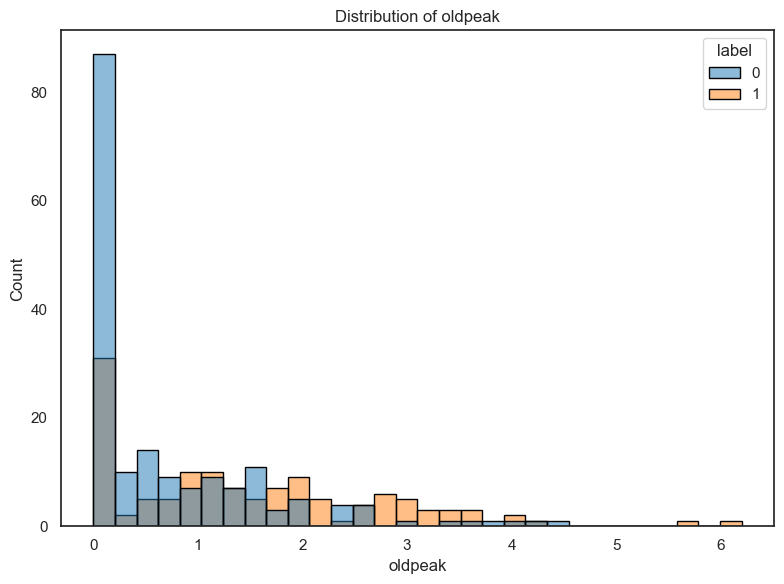

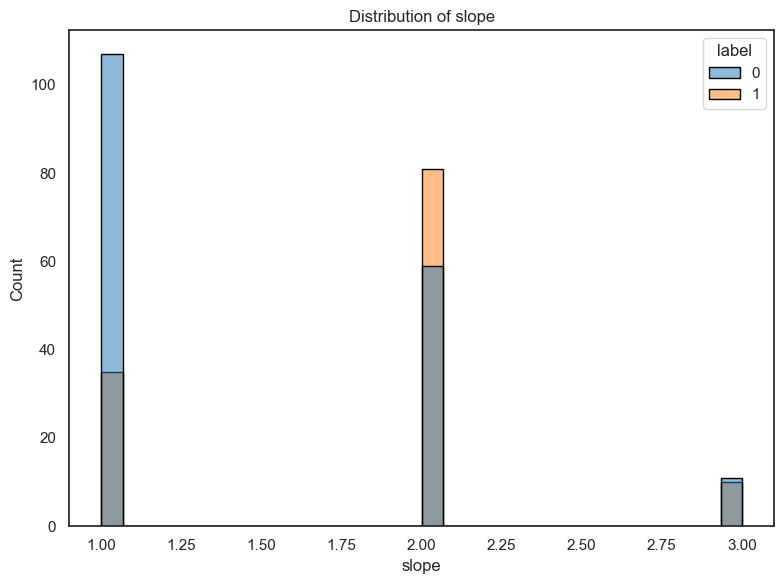

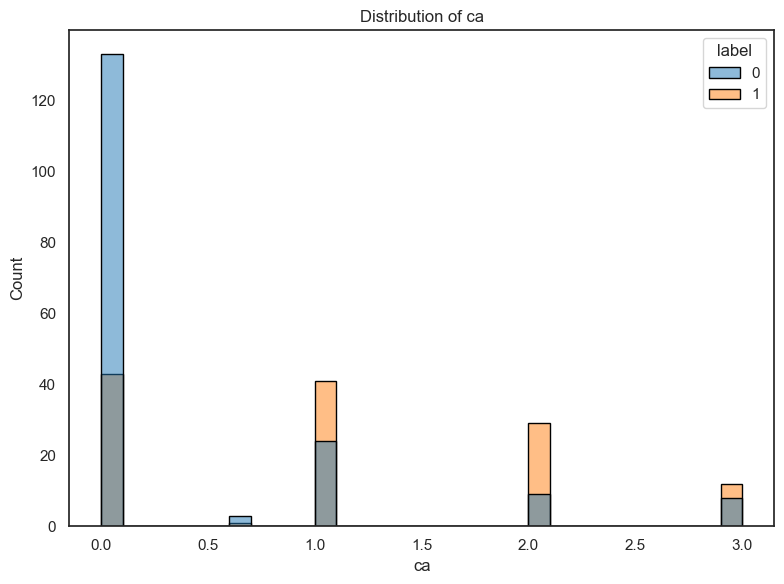

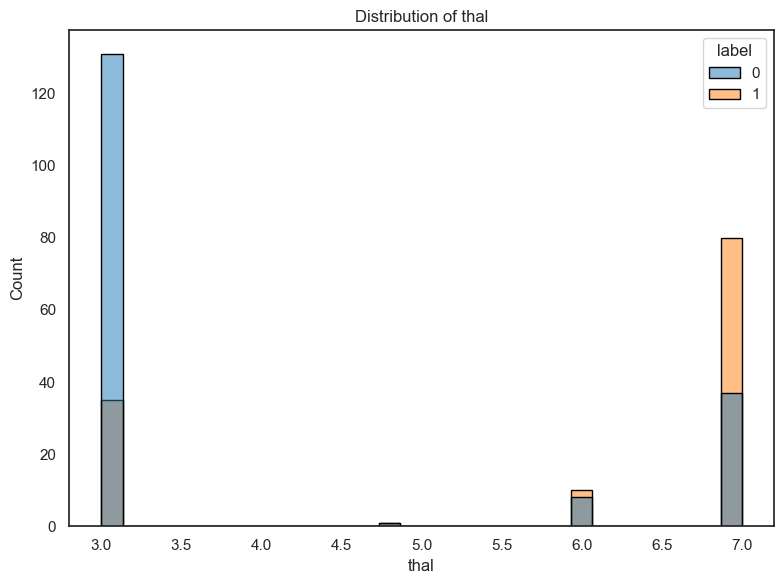

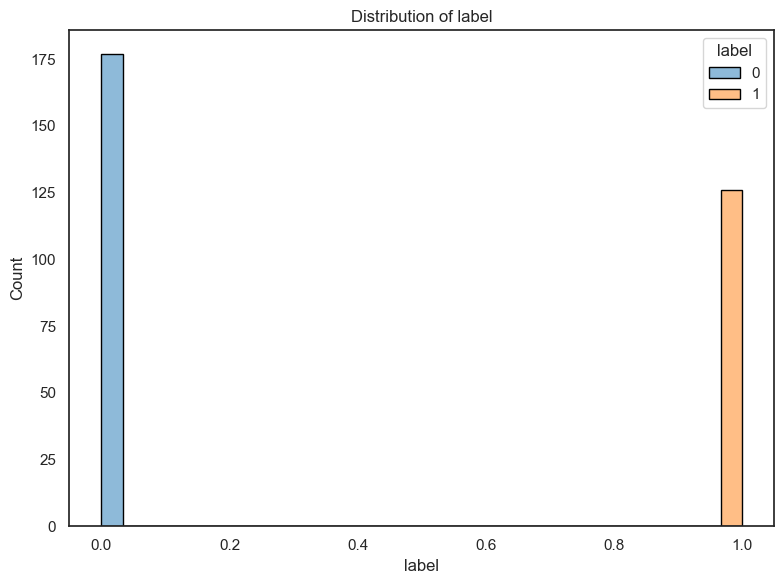

In [16]:
plot_histograms(X,y)

In [18]:
# Split the data into training and testing sets

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [19]:
# Train logistic regression model
from sklearn.linear_model import LogisticRegression
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [21]:
# Model Performance

from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Use the test data to evaluate the model's preformance.
y_pred = logistic_model.predict(X_test)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86        36
           1       0.83      0.76      0.79        25

    accuracy                           0.84        61
   macro avg       0.83      0.82      0.83        61
weighted avg       0.84      0.84      0.83        61



**Logistic regression model** achieved an overall **accuracy of 84%**. 

For Class 0 (negative class), it performed well with a **precision of 0.84**, a **recall of 0.89**, and an **F1-score of 0.86**, indicating it **correctly identified most negative cases while maintaining precision**. 

For Class 1 (positive class), which had a smaller support of 25 instances compared to 36 for Class 0, the model showed slightly lower performance, with a precision of 0.83, a recall of 0.76, and an F1-score of 0.79, **reflecting some difficulty in identifying all positive cases**.

The best metric to focus on depends on the **intention of the intervention**. 

For example, if the **intervention for a positive test is mild** (e.g., recommending a change in diet), **recall** would be prioritized to minimize false negatives. 

However, if the **intervention is serious** (e.g., heart surgery), **precision** would be more critical to avoid false positives. 

**F1-score** serves as a balanced middle ground, combining both precision and recall. Ultimately, the choice of the metric should be guided by subject matter experts, especially in medical applications where the stakes are high, and the implications of errors vary significantly.




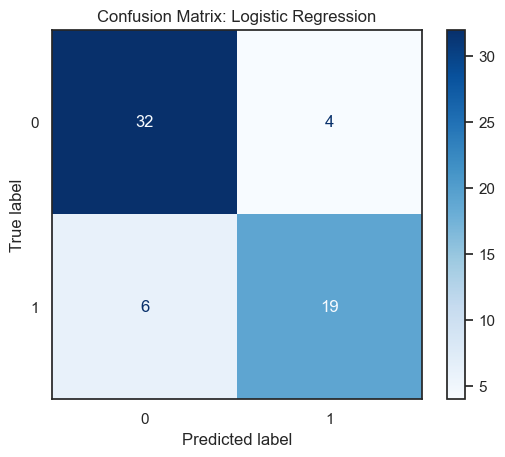

In [23]:
ConfusionMatrixDisplay.from_estimator(logistic_model, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix: Logistic Regression")
plt.show()

## <a id='toc2_4_'></a>[Interpreting Logistic Regression Coefficient](#toc0_)

**Logistic regression coefficients** represent the log-odds of the target variable (e.g., the probability of the positive class) changing with a one-unit increase in the corresponding feature, assuming all other features are held constant.


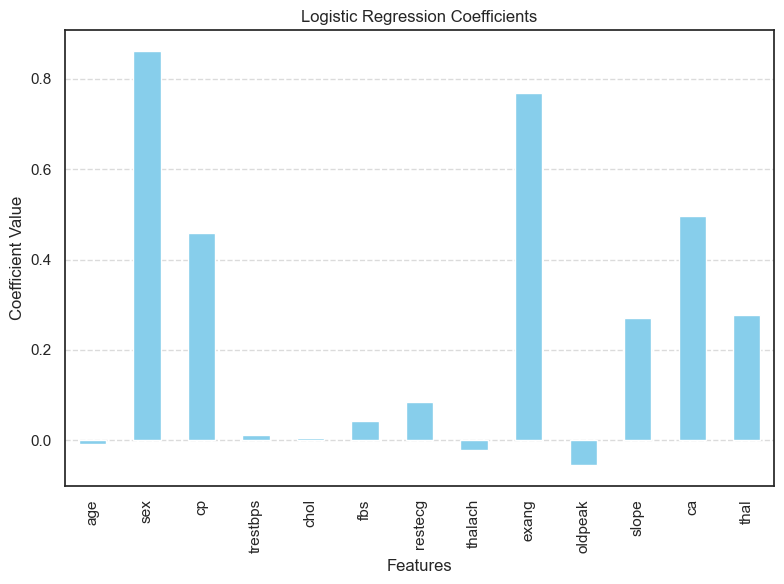

In [24]:
plt.figure(figsize=(8, 6))
coefficients = pd.Series(logistic_model.coef_[0], index=X.columns)  # Extract coefficients
coefficients.plot(kind='bar', color='skyblue')  # Plot as a bar chart
plt.title("Logistic Regression Coefficients")
plt.xlabel("Features")
plt.ylabel("Coefficient Value")
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid for readability
plt.tight_layout()
plt.show()


The bar chart shows the **coefficients** for each feature in the logistic regression model, ranked by **magnitude**. Here’s how to interpret the key points:



**Sex** has the largest positive coefficient (~0.8), indicating it is the **strongest predictor of the positive class**. This suggests that being male (if encoded as 1) significantly increases the likelihood of the positive class (e.g., heart disease).

**Exang** (exercise-induced angina) is another important predictor, positively associated with the positive class.

### <a id='toc2_4_1_'></a>[Positive Coefficients](#toc0_)

**Features with positive coefficients** (e.g., sex, exang, ca) increase the odds of the positive class as their values increase.

For example, a higher value in ca (number of major vessels colored by fluoroscopy) is linked to higher chances of the positive class.

### <a id='toc2_4_2_'></a>[Negative Coefficients](#toc0_)

Features like oldpeak (ST depression) and thalach (maximum heart rate achieved) have negative coefficients, indicating that **higher values decrease the odds of the positive class**.

For instance, higher thalach (higher heart rate during exercise) reduces the likelihood of heart disease.

### <a id='toc2_4_3_'></a>[Features Close to Zero](#toc0_)

Features like age and chol have coefficients close to zero, suggesting they contribute minimally to the prediction in this model.

### <a id='toc2_4_4_'></a>[Note: Standardizing features](#toc0_)

**Standardizing features** levels the playing field, ensuring that all coefficients are **comparable** regardless of their original scale. 

This helps the model assign weights more accurately based on the actual predictive power of each feature, improving both the performance and interpretability of logistic regression.

 we leave it to you as an exercise to you.


## <a id='toc2_5_'></a>[Standardizing Data Using StandardScaler() for Logistic Regression](#toc0_)


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86        36
           1       0.83      0.76      0.79        25

    accuracy                           0.84        61
   macro avg       0.83      0.82      0.83        61
weighted avg       0.84      0.84      0.83        61



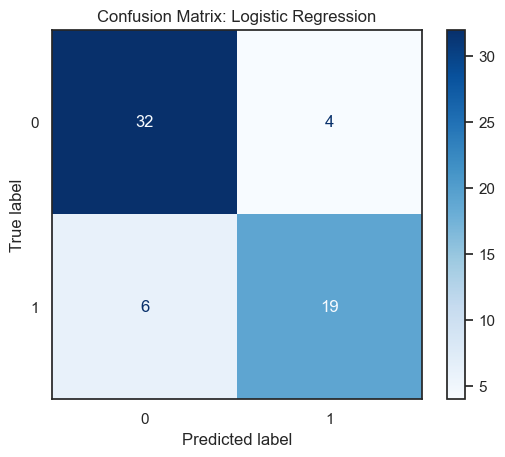

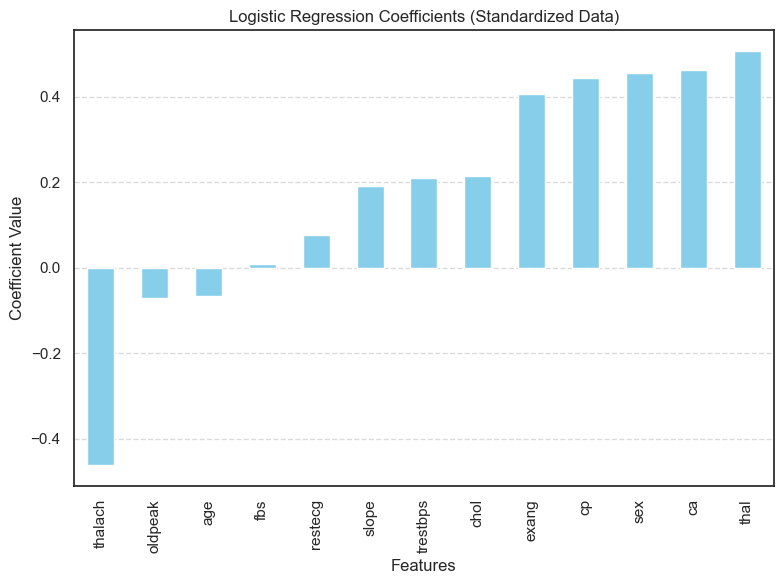

In [25]:
from sklearn.preprocessing import StandardScaler
# Step 1: Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit on training data and transform it
X_test_scaled = scaler.transform(X_test)       # Transform the test data using the same scaler

# Step 2: Train logistic regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train_scaled, y_train)  # Train the model on the standardized data

# Step 3: Evaluate the model
y_pred_logistic = logistic_model.predict(X_test_scaled)

# Print classification report
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logistic))

# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(logistic_model, X_test_scaled, y_test, cmap="Blues")
plt.title("Confusion Matrix: Logistic Regression")
plt.show()

# Step 5: Plot logistic regression coefficients
plt.figure(figsize=(8, 6))
coefficients = pd.Series(logistic_model.coef_[0], index=X.columns)
coefficients.sort_values().plot(kind='bar', color='skyblue')
plt.title("Logistic Regression Coefficients (Standardized Data)")
plt.xlabel("Features")
plt.ylabel("Coefficient Value")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## <a id='toc2_6_'></a>[Random Forests](#toc0_)

**Random Forests**  usually outperform simpler models like logistic regression due to their ability to handle complex, non-linear relationships and interactions between features. 


However, their interpretability is often a challenge because they are **ensemble models** combining many decision trees. 

In this case, the Random Forest model performs comparably to logistic regression, but to better understand the model's behavior and feature impact, we will use **Partial Dependence Plots (PDPs)** to interpret how individual features influence the predictions.

First lets train a random forest model.


In [27]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        36
           1       0.80      0.80      0.80        25

    accuracy                           0.84        61
   macro avg       0.83      0.83      0.83        61
weighted avg       0.84      0.84      0.84        61



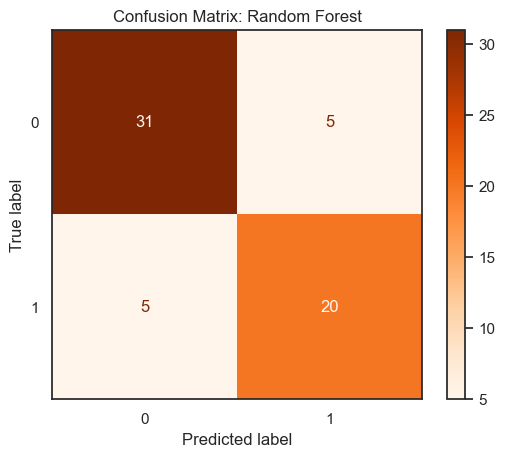

In [29]:
# Predictions and report
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test, cmap="Oranges")
plt.title("Confusion Matrix: Random Forest")
plt.show()

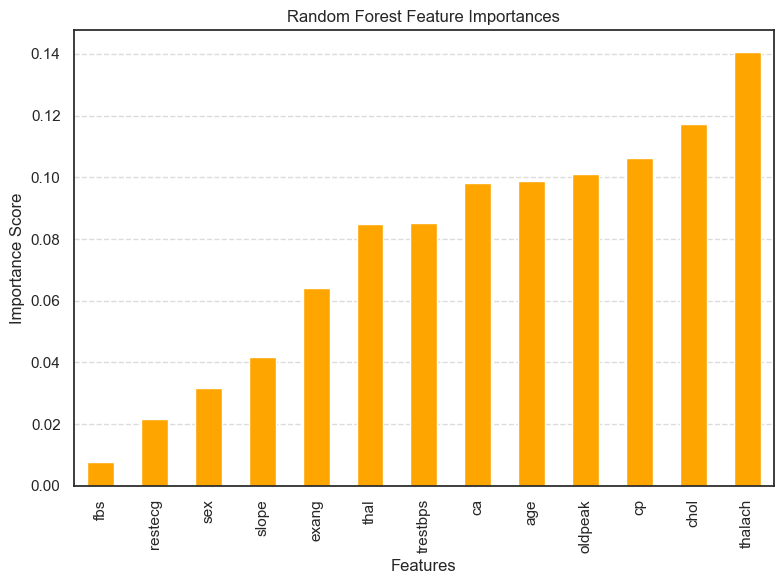

In [30]:
# Plot feature importances
plt.figure(figsize=(8, 6))
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='bar', color='orange')
plt.title("Random Forest Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [31]:
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X, y)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


# <a id='toc3_'></a>[Partial Dependence Plot](#toc0_)


### <a id='toc3_1_1_'></a>[Partial Dependence from Scratch with Python](#toc0_)

Recall for a single feature $X_S$, we will calculate the partial dependence for $X_S$, where the feature of interest is "Feature1":

$
\hat{f}_{X_S}(x_S) = \frac{1}{n} \sum_{i=1}^n \hat{f}(x_S, X_{-S,i})
$

Where:

- $ X_S $: The feature of interest, "Feature 1".
- $X_{-S} $: The complement feature set, marginalized over, including "Feature 2" and "Feature 3".
- $ n $: The number of samples in the dataset (e.g. 500).

This equation isolates the effect of $ X_S $ by averaging the model predictions over all possible values of $ X_{-S} $, providing insight into the marginal relationship between $X_S $ and the target.

$x_s $ the feature of interest (e.g., Feature1) to a specific value (deterministic) from the range we define (the grid). We can do this as follows:



In [32]:
feature_of_interest = "age"
grid_points = 50

# Create the grid for Feature1
Xs = np.linspace(X[feature_of_interest].min(), X[feature_of_interest].max(), grid_points)
print(f"First five samples of X_s: \n{Xs[:5]}")

# Initialize the array to store partial dependence values
partial_dependence = np.zeros(grid_points)


First five samples of X_s: 
[29.         29.97959184 30.95918367 31.93877551 32.91836735]


In [33]:
temp_X = X.copy()

for n, xs in enumerate(Xs):

    temp_X[feature_of_interest] = xs  # Add the fixed Feature1 column
    # Predict using the model for all rows f(x)
    predictions = rf_model.predict_proba(temp_X)[:,1]
    # Store the mean prediction for this grid point 
    partial_dependence[n] = predictions.mean()
      

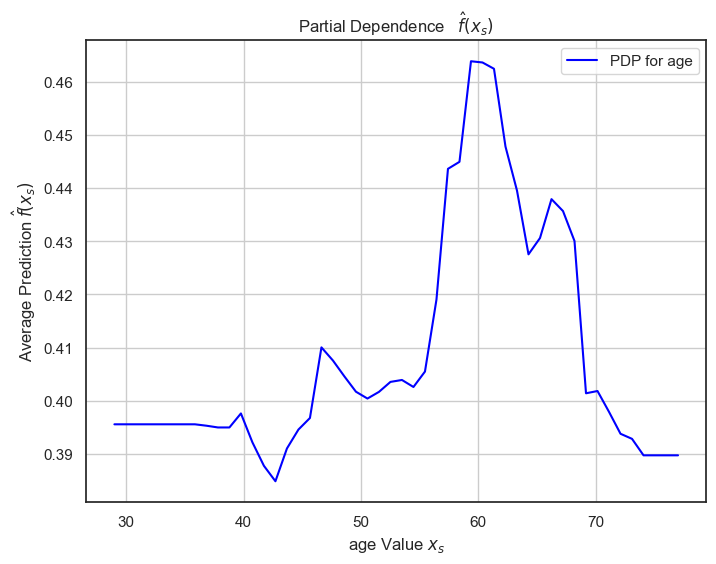

In [34]:
plt.figure(figsize=(8, 6))
plt.plot(Xs, partial_dependence, label=f"PDP for {feature_of_interest}", color="blue")
plt.xlabel(f"{feature_of_interest} Value $x_s$")
plt.ylabel(f"Average Prediction $\hat{{f}}(x_s)$")
plt.title(f"Partial Dependence   $\hat{{f}}(x_s)$")
plt.legend()
plt.grid()
plt.show()

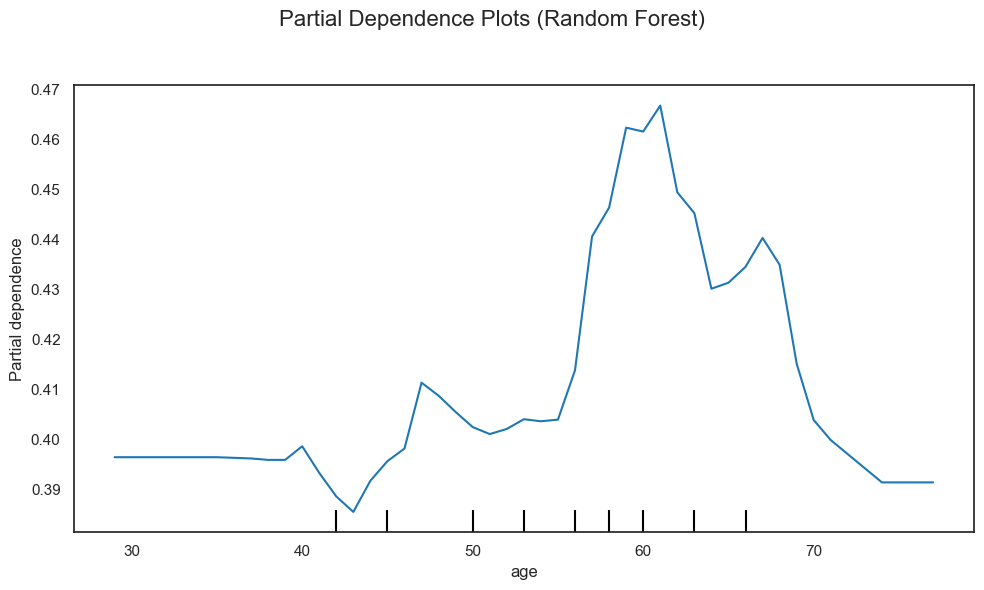

In [35]:
from sklearn.inspection import PartialDependenceDisplay
features_to_plot = [0]

fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(
    rf_model, 
    X_train, 
    features=features_to_plot, 
    feature_names=X.columns, 
    grid_resolution=50, 
    ax=ax)

plt.suptitle("Partial Dependence Plots (Random Forest)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout for the title
plt.show()


We observe that as **age increases**, the probability of an event (e.g., a heart attack) remains relatively constant initially but then suddenly rises in the mid-50s and decreases again in the 70s. 

Although the units are different, the relationship with age did not appear to have a significant effect overall when using feature importance methods.

However, for individuals in their mid-50s and above, the model reveals localized variations in risk. This illustrates the usefulness of partial dependence plots in capturing how local changes in feature values can affect predictions, even when global feature importance methods fail to highlight such patterns.

You can generate **PDPs** for all features in the dataset  using a Random Forest model. For each feature, it **creates a separate plot** showing how the feature's values influence the model's predictions, while averaging over the effects of all other features. 

The Partial Dependence Plots (PDPs) in scikit-learn **do not** handle categorical variables well by default, as they assume continuous or ordinal input. To address this, we add a flag to skip certain categorical features (e.g., 'sex', 'fbs', and 'exang') during the plot generation. For a detailed explanation on how to handle PDPs for categorical variables, refer to [Interpretable Machine Learning by Christoph Molnar](https://christophm.github.io/interpretable-ml-book/pdp.html).



Processing Feature Index: 0, Feature Name: age


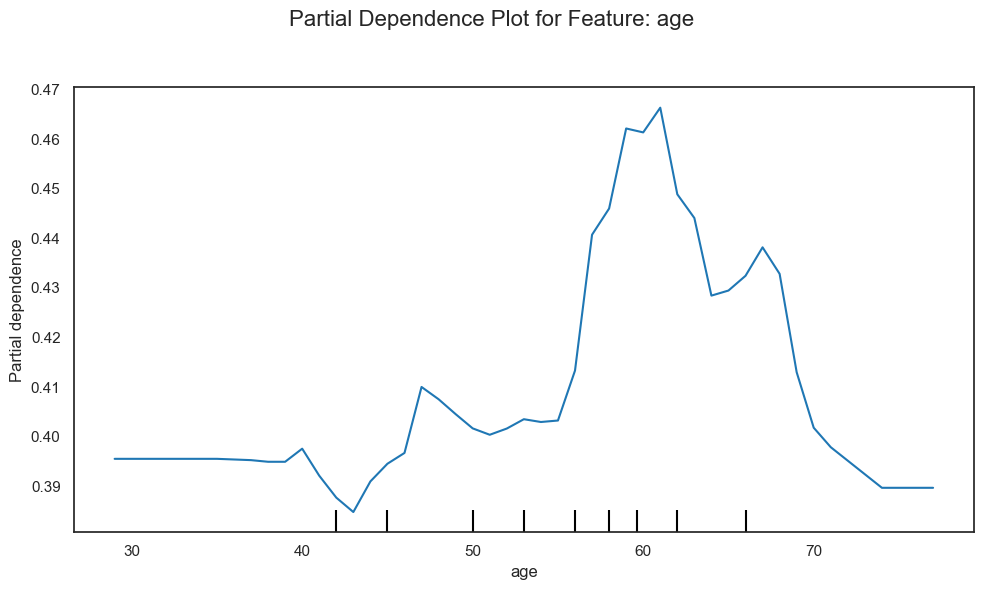

Processing Feature Index: 1, Feature Name: sex
Processing Feature Index: 2, Feature Name: cp


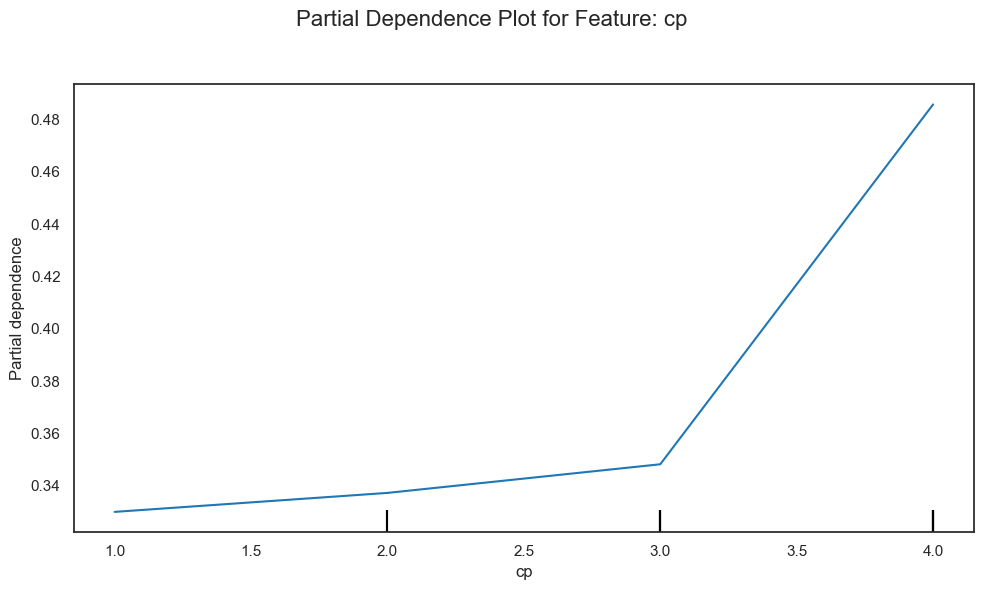

Processing Feature Index: 3, Feature Name: trestbps


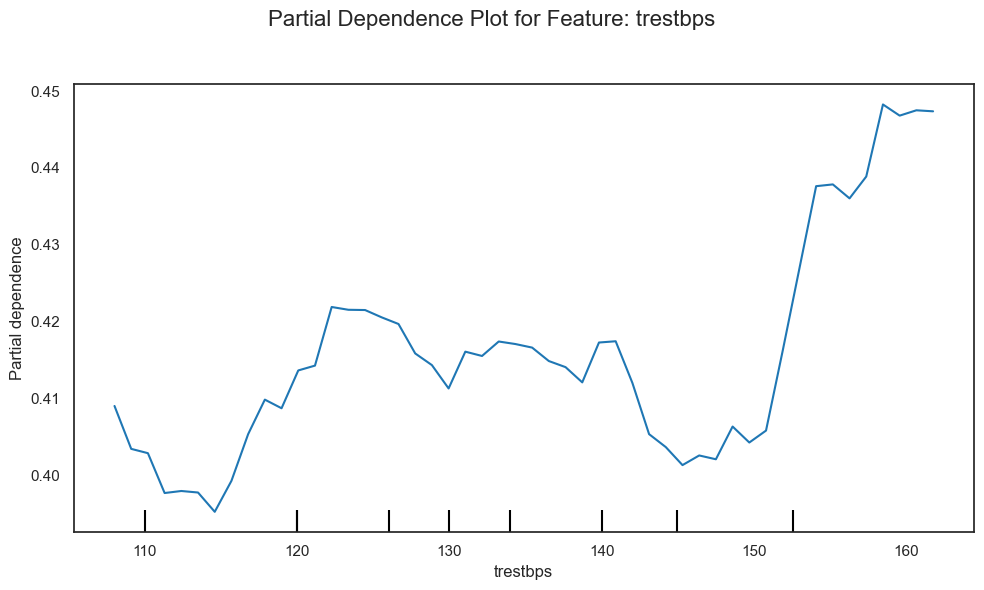

Processing Feature Index: 4, Feature Name: chol


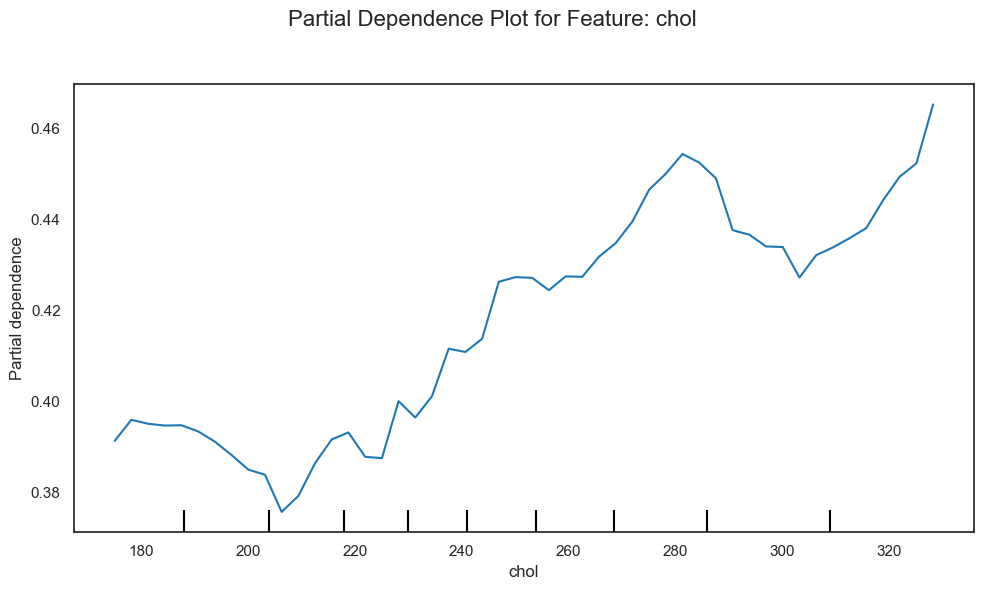

Processing Feature Index: 5, Feature Name: fbs
Processing Feature Index: 6, Feature Name: restecg


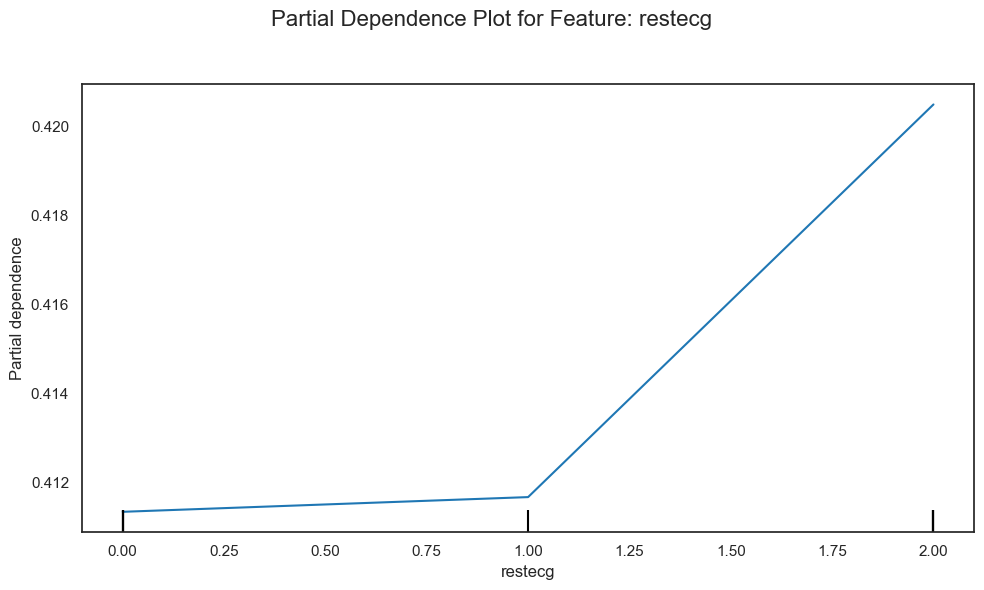

Processing Feature Index: 7, Feature Name: thalach


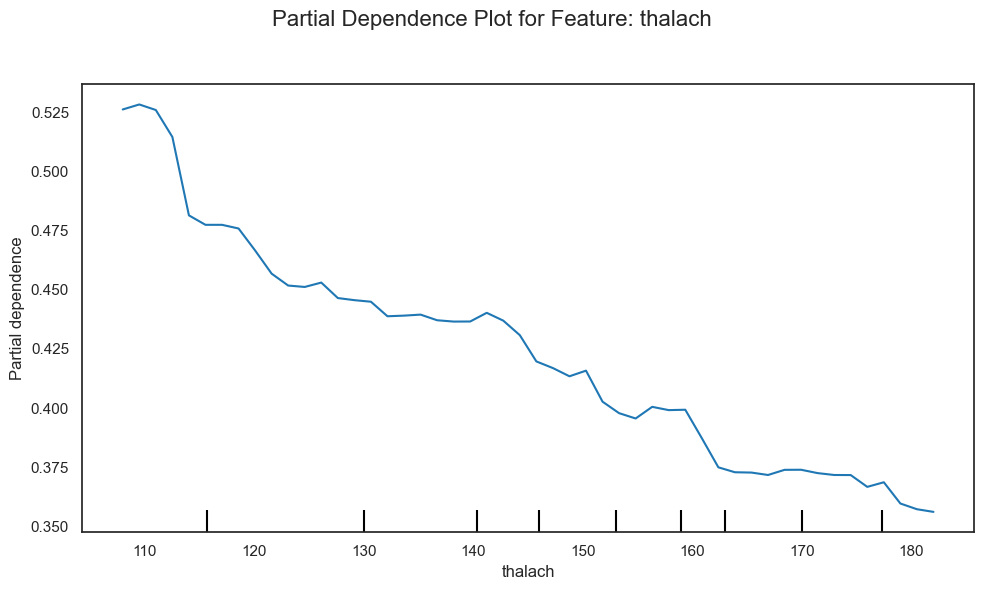

Processing Feature Index: 8, Feature Name: exang
Processing Feature Index: 9, Feature Name: oldpeak


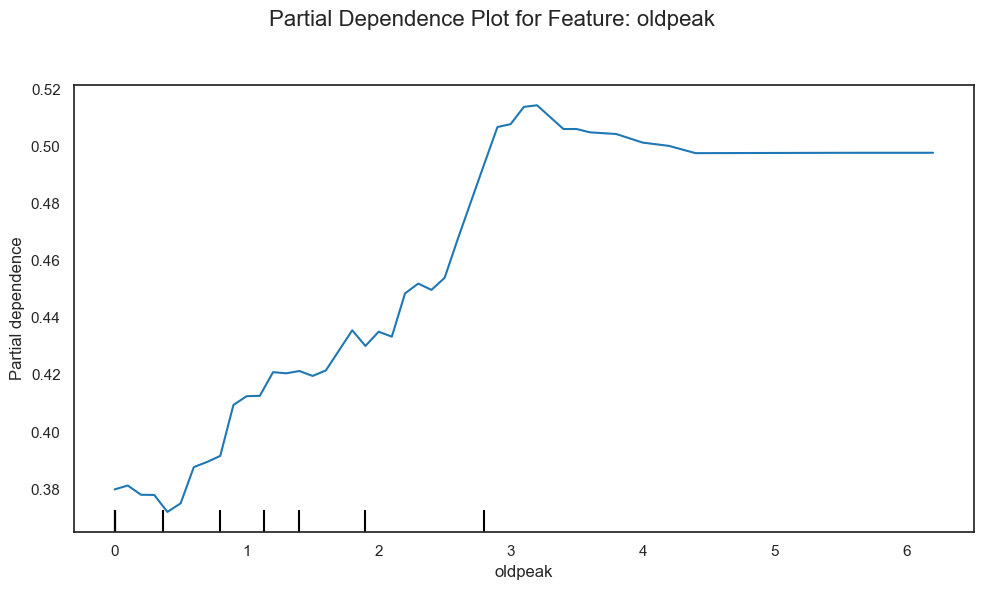

Processing Feature Index: 10, Feature Name: slope


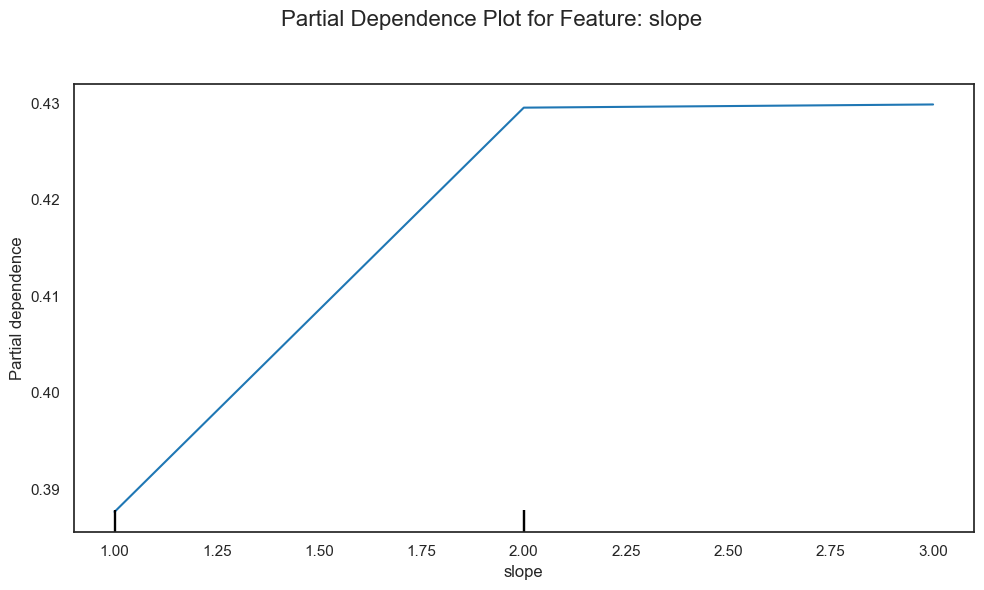

Processing Feature Index: 11, Feature Name: ca


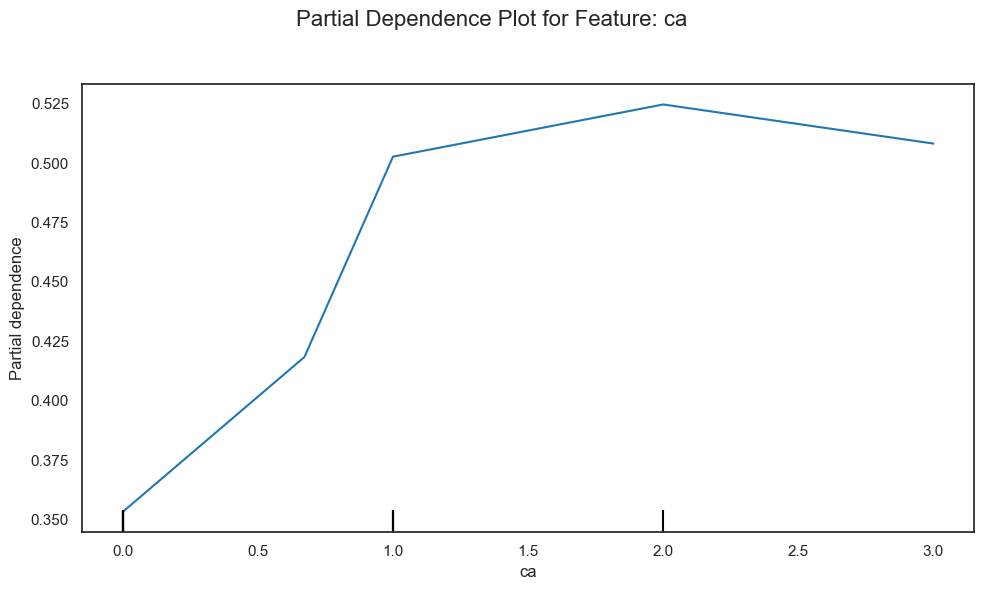

Processing Feature Index: 12, Feature Name: thal


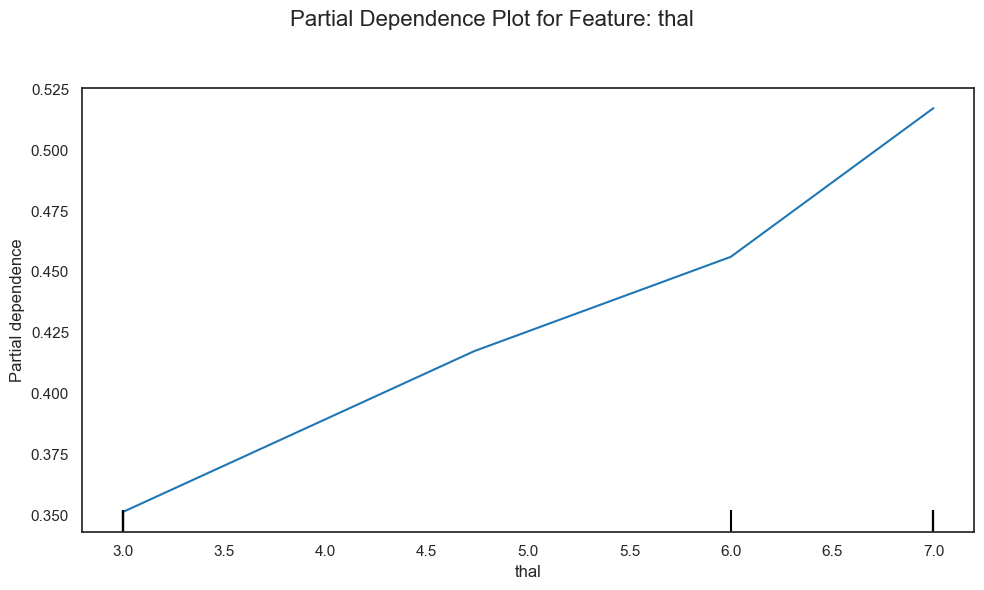

In [36]:
# Verify feature names and indices
feature_names = X.columns

for i, feature_name in enumerate(feature_names):
    print(f"Processing Feature Index: {i}, Feature Name: {feature_name}")
    
    # Plot PDP for the feature
    if not(feature_name in ['sex', 'fbs', 'exang']):
        fig, ax = plt.subplots(figsize=(10, 6))
        PartialDependenceDisplay.from_estimator(
            rf_model,
            X,
            features=[i],  # Use valid feature index
            feature_names=feature_names,
            grid_resolution=50,
            ax=ax
        )
        plt.suptitle(f"Partial Dependence Plot for Feature: {feature_name}", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

## <a id='toc3_2_'></a>[Explanation for 2D Partial Dependence Plot (PDP)](#toc0_)

A **2D Partial Dependence Plot (PDP)** visualizes the combined effect of two features (e.g., **fasting blood sugar (fbs)** and **cholesterol (chol)**) on a model's predictions, while averaging over the effects of all other features in the dataset. It helps identify interactions between the **two features** and their **joint impact** on the predicted outcome.

### <a id='toc3_2_1_'></a>[Formula for 2D PDP](#toc0_)

The formula for calculating the 2D PDP is:

$
\hat{f}_{X_S}(X_s) = \frac{1}{N} \sum_{i=1}^{N} f\big(X_s, X_{-s}^{(i)}\big)
$

Where:
- $X_s = \{fbs, chol\}$: The two features of interest being varied.
- $X_{-s}$: The rest of the features in the dataset, which are held constant at their observed values.
- $f(X_s, X_{-s})$: The model's prediction function for a given combination of $X_s$ and $X_{-s}$.
- $N$: The total number of samples in the dataset.
- $\hat{f}_{X_S}(X_s)$: The average prediction for each combination of the selected features ($X_s$).



This formula marginalizes the effects of all other features $X_{-s}$ by averaging the model's predictions for every possible combination of the two features $X_s$, isolating their joint influence on the target variable.



You can generate 2D PDPs for the features **thalach** (maximum heart rate achieved), **chol** (cholesterol), and their combined interaction using a trained Random Forest model. 

The `features_to_plot` parameter specifies both individual features (`'thalach'` and `'chol'`) and their pair (`('thalach', 'chol')`) for a 2D PDP. While this example uses feature names, like before  numerical indices corresponding to the features in the dataset can also be used of vice versa. 

The `grid_resolution=50` ensures a smooth and detailed plot by evaluating the model at 50 evenly spaced points along the range of each feature. 

The output includes **1D PDPs** for `thalach` and `chol`, which show their isolated effects on the predictions, and a **2D PDP**, visualized as a heatmap, depicting the interaction between `thalach` and `chol` in influencing the predicted probabilities. 

This combination provides more insightful interpretations compared to other pairs, highlighting their significance in the model.


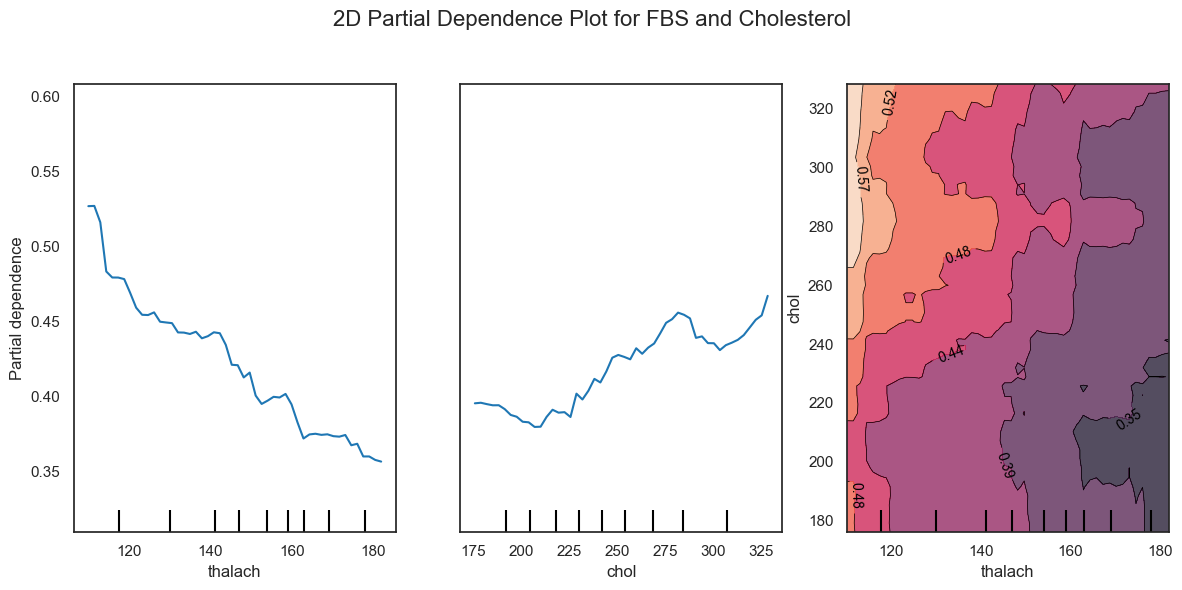

In [37]:
# Define the features for the 2D PDP
features_to_plot = ['thalach', 'chol',('thalach', 'chol')]  # Fasting blood sugar and cholesterol

# Generate the 2D PDP
fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(
    rf_model,
    X_train,
    features=features_to_plot,
    grid_resolution=50,
    ax=ax,
)
plt.suptitle("2D Partial Dependence Plot for FBS and Cholesterol", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout for the title
plt.show()

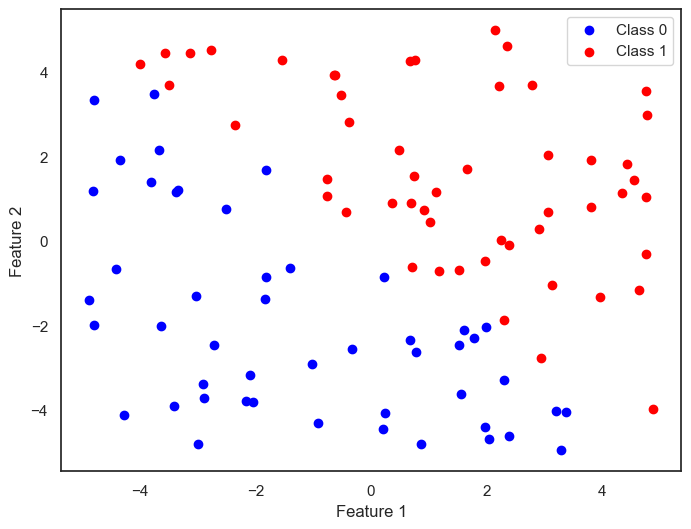

In [38]:
def create_separable_data(beta_1, beta_2, n_samples=100, random_seed=0):
    np.random.seed(random_seed)
    
    # Generate random features
    X = 10*np.random.rand(n_samples, 2)-5   # Two features ranging from 0 to 10

    # Define the linear boundary: beta_1 * x1 + beta_2 * x2 = 0
    # Points for which beta_1 * x1 + beta_2 * x2 > 0 will be in class 1, otherwise class 0
    y = (beta_1 * X[:, 0] + beta_2 * X[:, 1] > 0).astype(int)
    return X, y
X, y = create_separable_data(beta_1=1, beta_2=1, n_samples=100, random_seed=0)

# Plot the points and decision boundary
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0, 0], X[y == 0, 1], color='blue', label='Class 0')
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='red', label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

In [39]:
clf = LogisticRegression(random_state=0).fit(X, y)

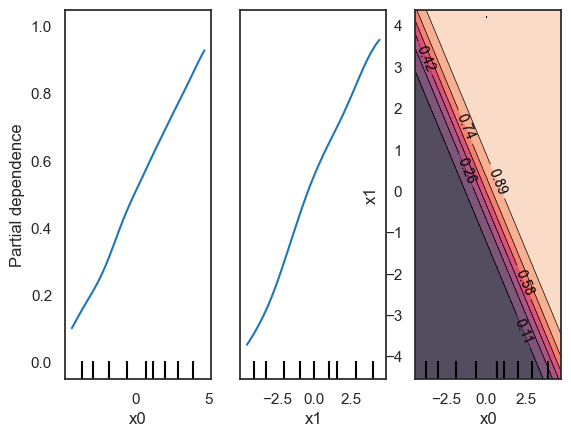

In [40]:
PartialDependenceDisplay.from_estimator(clf, X, features=[0,1,(0,1)])
plt.show()